# CZ1016 : Assignment

- Student: Pooja Srinivas Nag
- Class: DSAI2

---

### Essential Libraries

Let us begin by importing the essential Python Libraries.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

import re # for expression operations 
import nltk # natural language toolkit
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from nltk.tokenize import word_tokenize 

%matplotlib inline
plt.style.use('seaborn-deep')

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

import wordcloud

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

---

### Setup : Import the Dataset

Dataset : **"smsdata.txt"** (use `read_table` function from Pandas to import)     
After importing, take a quick look at the dataset using the `head` function.

In [2]:
# Read the dataset as per the format
# response label <tab> sms as string
smsData = pd.read_table('smsdata.txt', sep = "\t", header = None)
smsData.head()

,0,1
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Fix the headers / column labels
smsData.columns = ["label", "text"]
smsData.head()

,label,text
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Basic information about the data
smsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null object
text     5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
# add a numerical label for spam
# 0: 'good' text
# 1: 'spam' text

smsData['spam'] = smsData['label'].map({'spam':1, 'good':0}).astype(int)
smsData.head()

,label,text,spam
0,good,"Go until jurong point, crazy.. Available only ...",0
1,good,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,good,U dun say so early hor... U c already then say...,0
4,good,"Nah I don't think he goes to usf, he lives aro...",0


## Data Visualisation

In [6]:
smsData.groupby('label').describe()

spam                                   
        count mean  std  min  25%  50%  75%  max
label                                           
good   4825.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
spam    747.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [7]:
smsData.label.value_counts()

good    4825
spam     747
Name: label, dtype: int64

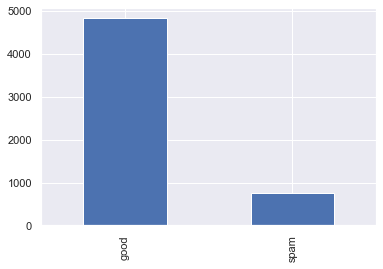

In [8]:
# add x and y axes

smsData.label.value_counts().plot.bar()

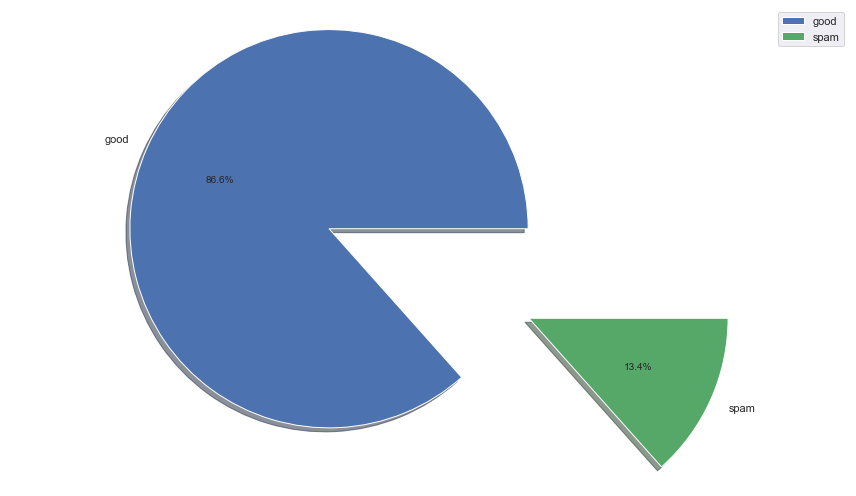

In [9]:
explode = (0.1,1)
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.pie(smsData['label'].value_counts(), explode = explode, labels=['good', 'spam'], autopct = '%1.1f%%', shadow = True)
#Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.legend()
plt.show()

## Features

1. Character Count
2. Word Count
3. Average Word Length 
4. Number of Stopwords
5. Number of Punctuations
6. Number of Upper Case Words
7. Number of Numerics
8. Number of Rare Words
9. Number of Words from Top 100 words in good messages
10. Number of Words from Top 100 words in spam messages 

#### Feature #1: Character Count

In [10]:
# count the number of characters in each text
smsData['char count']=smsData['text'].apply(len) 
smsData.head()

,label,text,spam,char count
0,good,"Go until jurong point, crazy.. Available only ...",0,111
1,good,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,good,U dun say so early hor... U c already then say...,0,49
4,good,"Nah I don't think he goes to usf, he lives aro...",0,61


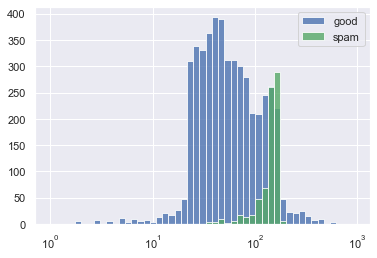

In [11]:
plt.xscale('log')
bins = 1.15**(np.arange(0,50))
plt.hist(smsData[smsData['label']=='good']['char count'],bins=bins,alpha=0.8)
plt.hist(smsData[smsData['label']=='spam']['char count'],bins=bins,alpha=0.8)
plt.legend(('good','spam'))
plt.show()

There exists only a few messages where the text is more likely to be a 
spam than a good message.

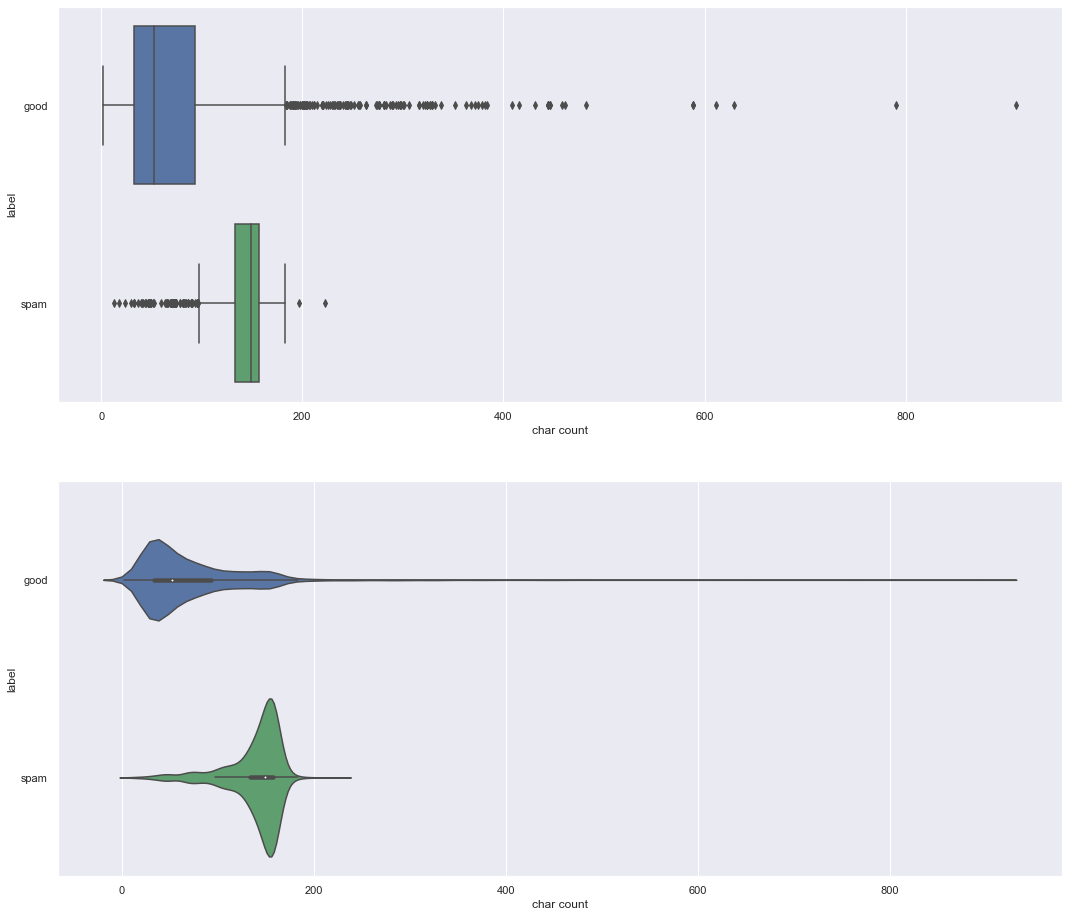

In [12]:
f, axes = plt.subplots(2, 1, figsize=(18,16))

sb.boxplot(x=smsData['char count'], y=smsData['label'], orient = "h", ax = axes[0])
sb.violinplot(x=smsData['char count'], y=smsData['label'], ax = axes[1])

From the boxplot and the violinplot, it is noticed that the character counts of 'spam' texts are higher than that of the 'good' texts. Since the overlap between 'spam' and 'good' text are relatively low, there is a relatively low chance of misclassification of 'spam' texts. Hence, character count may be a potentially good predictor. 

However, there are still overlaps between character counts of 'spam' and 'good' texts which may make the prediction inaccurate.

#### Feature #2: Word Count

In [13]:
# find the number of words 
smsData['word count']=smsData['text'].apply(lambda x:len(str(x).split(" ")))
smsData.head()

,label,text,spam,char count,word count
0,good,"Go until jurong point, crazy.. Available only ...",0,111,20
1,good,Ok lar... Joking wif u oni...,0,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,28
3,good,U dun say so early hor... U c already then say...,0,49,11
4,good,"Nah I don't think he goes to usf, he lives aro...",0,61,13


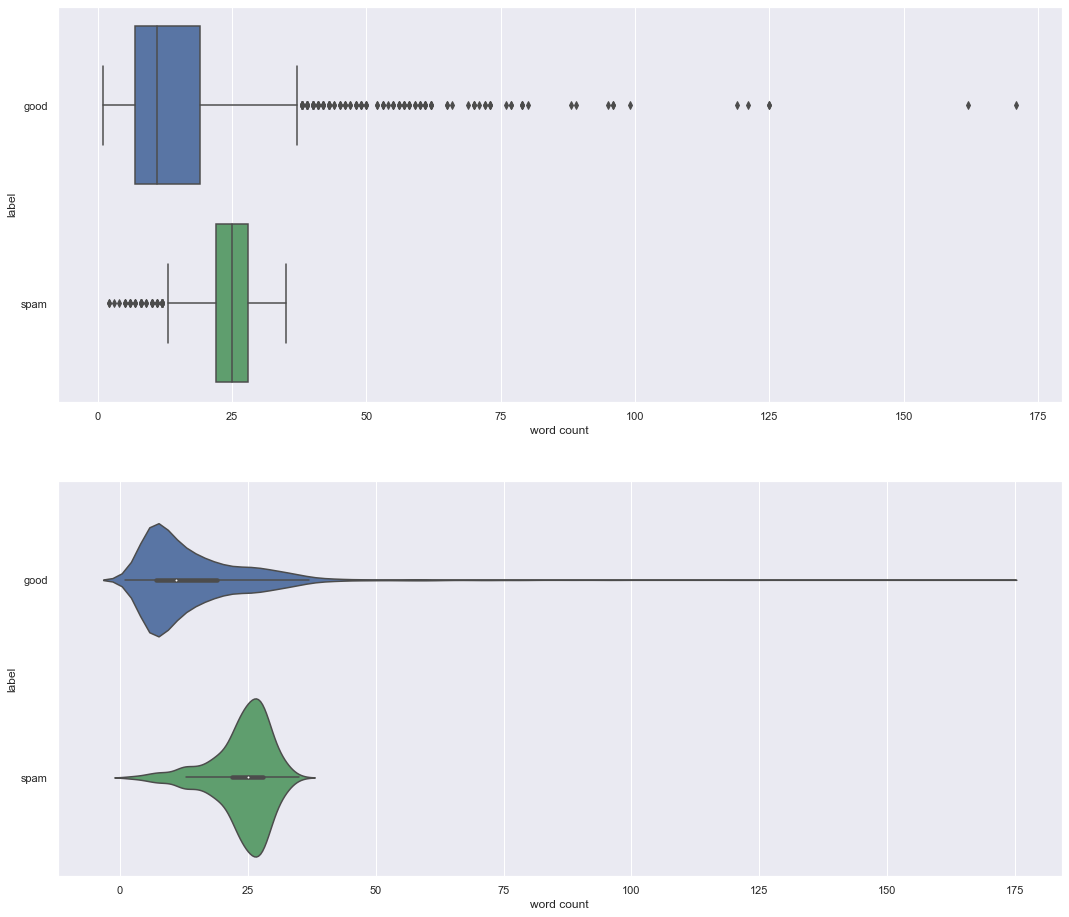

In [14]:
f, axes = plt.subplots(2, 1, figsize=(18,16))

sb.boxplot(x=smsData['word count'], y=smsData['label'], orient = "h", ax = axes[0])
sb.violinplot(x=smsData['word count'], y=smsData['label'], ax = axes[1])

#### Feature #3: Average Word Length

In [15]:
# find the average word length in each message 

def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))


smsData['avg word len']=smsData['text'].apply(lambda x:avg_word(x))
smsData.head()

,label,text,spam,char count,word count,avg word len
0,good,"Go until jurong point, crazy.. Available only ...",0,111,20,4.600000
1,good,Ok lar... Joking wif u oni...,0,29,6,4.000000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,28,4.571429
3,good,U dun say so early hor... U c already then say...,0,49,11,3.545455
4,good,"Nah I don't think he goes to usf, he lives aro...",0,61,13,3.769231


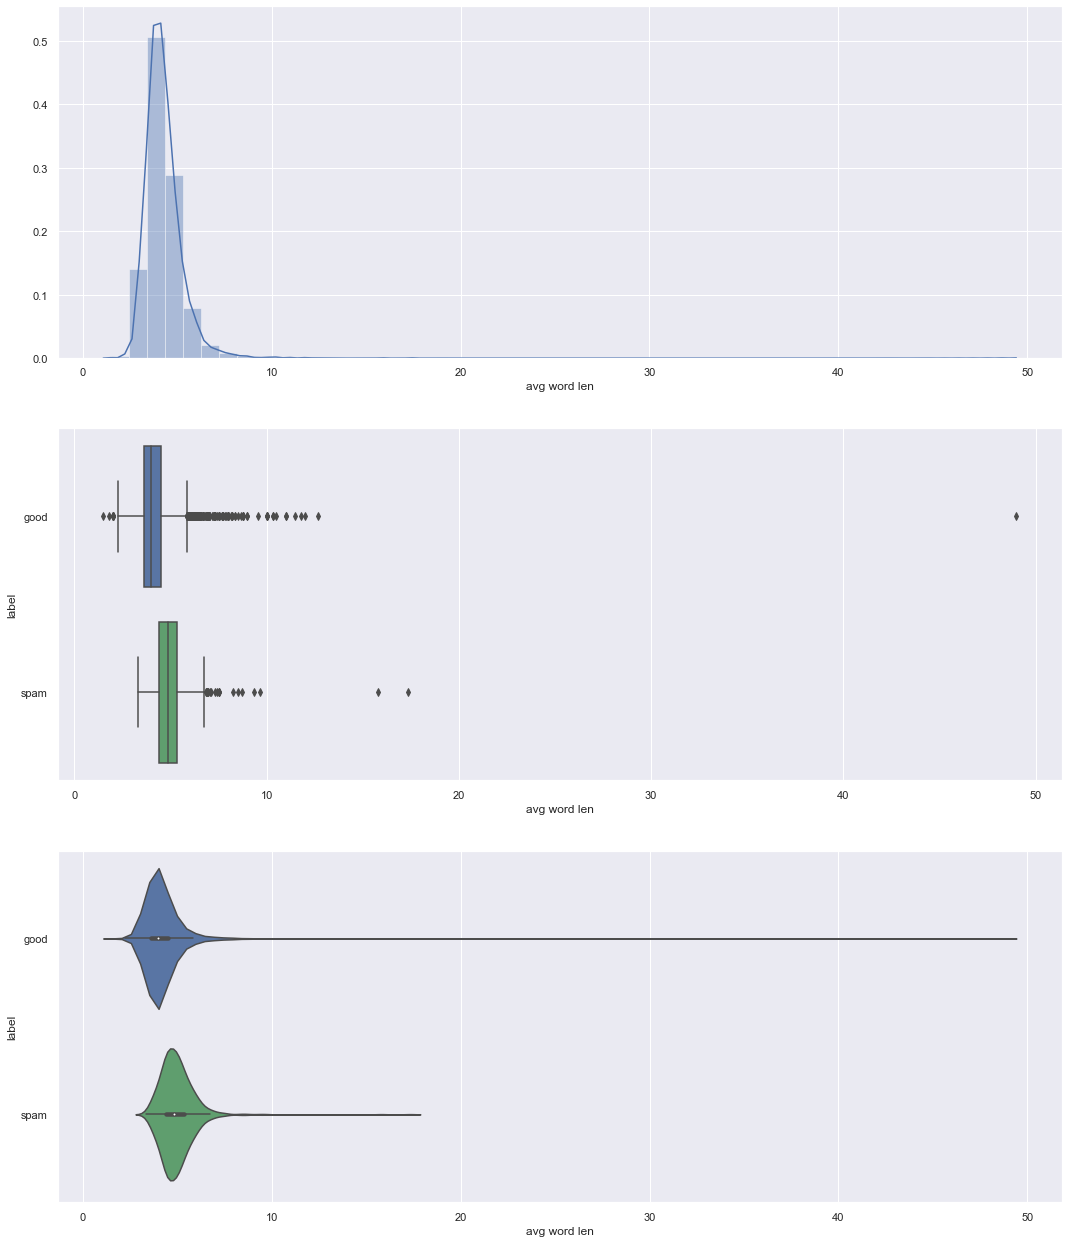

In [16]:
f, axes = plt.subplots(3, 1, figsize=(18,22))

sb.distplot(smsData['avg word len'], ax = axes[0])
sb.boxplot(x=smsData['avg word len'], y=smsData['label'], orient = "h", ax = axes[1])
sb.violinplot(x=smsData['avg word len'], y=smsData['label'], ax = axes[2])

It is noticed from the graphs that average word lengths of 'spam' texts are generally longer than that of 'good' texts. 

#### Feature #4: Number of Stopwords

In [17]:
# find the number of stopwords

from nltk.corpus import stopwords 
stop = stopwords.words('english') #creates a list with stopwords in english

smsData['stopwords']=smsData['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
smsData.head()

,label,text,spam,char count,word count,avg word len,stopwords
0,good,"Go until jurong point, crazy.. Available only ...",0,111,20,4.600000,4
1,good,Ok lar... Joking wif u oni...,0,29,6,4.000000,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,28,4.571429,5
3,good,U dun say so early hor... U c already then say...,0,49,11,3.545455,2
4,good,"Nah I don't think he goes to usf, he lives aro...",0,61,13,3.769231,5


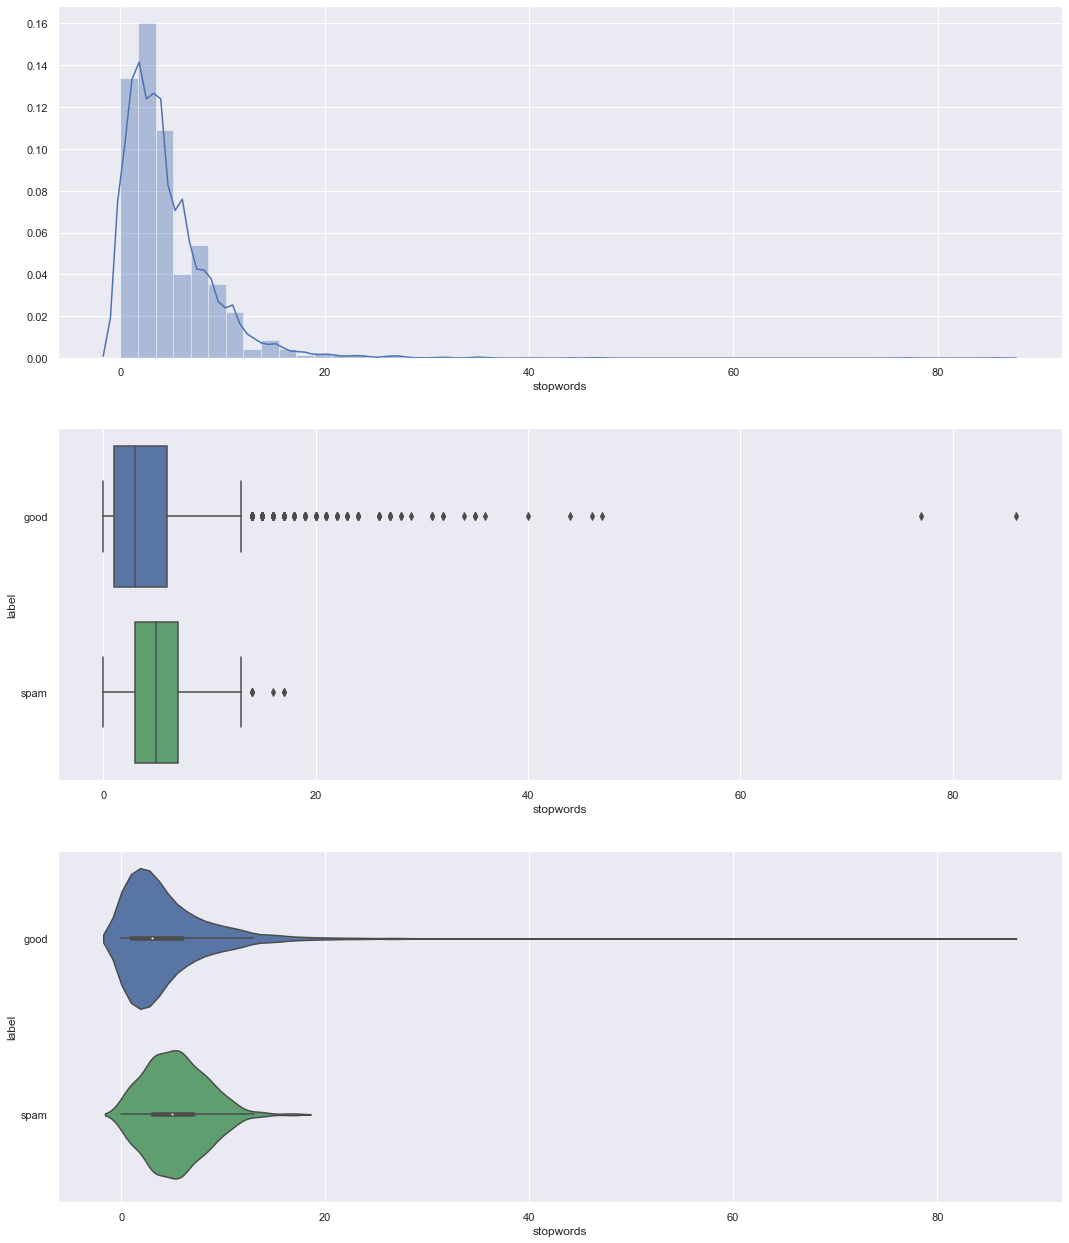

In [18]:
f, axes = plt.subplots(3, 1, figsize=(18,22))

sb.distplot(smsData['stopwords'], ax = axes[0])
sb.boxplot(x=smsData['stopwords'], y=smsData['label'], orient = "h", ax = axes[1])
sb.violinplot(x=smsData['stopwords'], y=smsData['label'], ax = axes[2])

The distributions of number of stopwords are slightly distint between 'spam' and 'good' texts, with 'good' texts having a generally smaller average word length.

#### Feature #5: Number of Punctuations

In [19]:
import string
punctuations = string.punctuation

In [20]:
# find the number of special characters

smsData['special char'] = smsData['text'].apply(lambda x:len([w for w in x.split() for y in w if (y in punctuations)]))
smsData.head()

#w - word / y - char

,label,text,spam,char count,word count,avg word len,stopwords,special char
0,good,"Go until jurong point, crazy.. Available only ...",0,111,20,4.600000,4,9
1,good,Ok lar... Joking wif u oni...,0,29,6,4.000000,0,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,28,4.571429,5,6
3,good,U dun say so early hor... U c already then say...,0,49,11,3.545455,2,6
4,good,"Nah I don't think he goes to usf, he lives aro...",0,61,13,3.769231,5,2


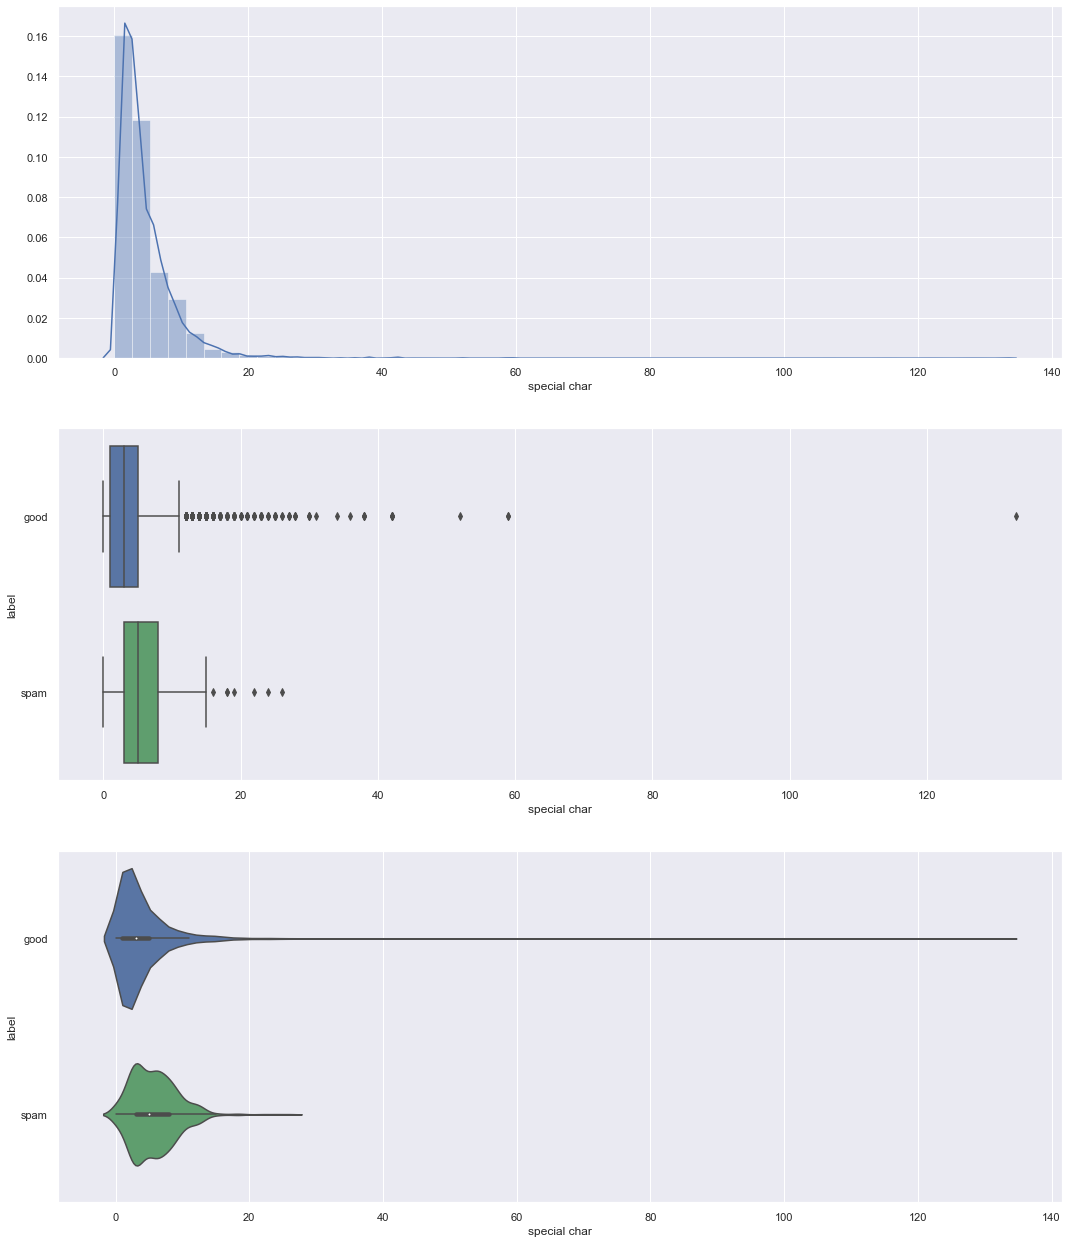

In [21]:
f, axes = plt.subplots(3, 1, figsize=(18,22))

sb.distplot(smsData['special char'], ax = axes[0])
sb.boxplot(x=smsData['special char'], y=smsData['label'], orient = "h", ax = axes[1])
sb.violinplot(x=smsData['special char'], y=smsData['label'], ax = axes[2])

#### Feature #6: Number of Numerics

In [22]:
# find the number of numbers

smsData['numerics'] = smsData['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
smsData.head()

,label,text,spam,char count,word count,avg word len,stopwords,special char,numerics
0,good,"Go until jurong point, crazy.. Available only ...",0,111,20,4.600000,4,9,0
1,good,Ok lar... Joking wif u oni...,0,29,6,4.000000,0,6,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,28,4.571429,5,6,2
3,good,U dun say so early hor... U c already then say...,0,49,11,3.545455,2,6,0
4,good,"Nah I don't think he goes to usf, he lives aro...",0,61,13,3.769231,5,2,0


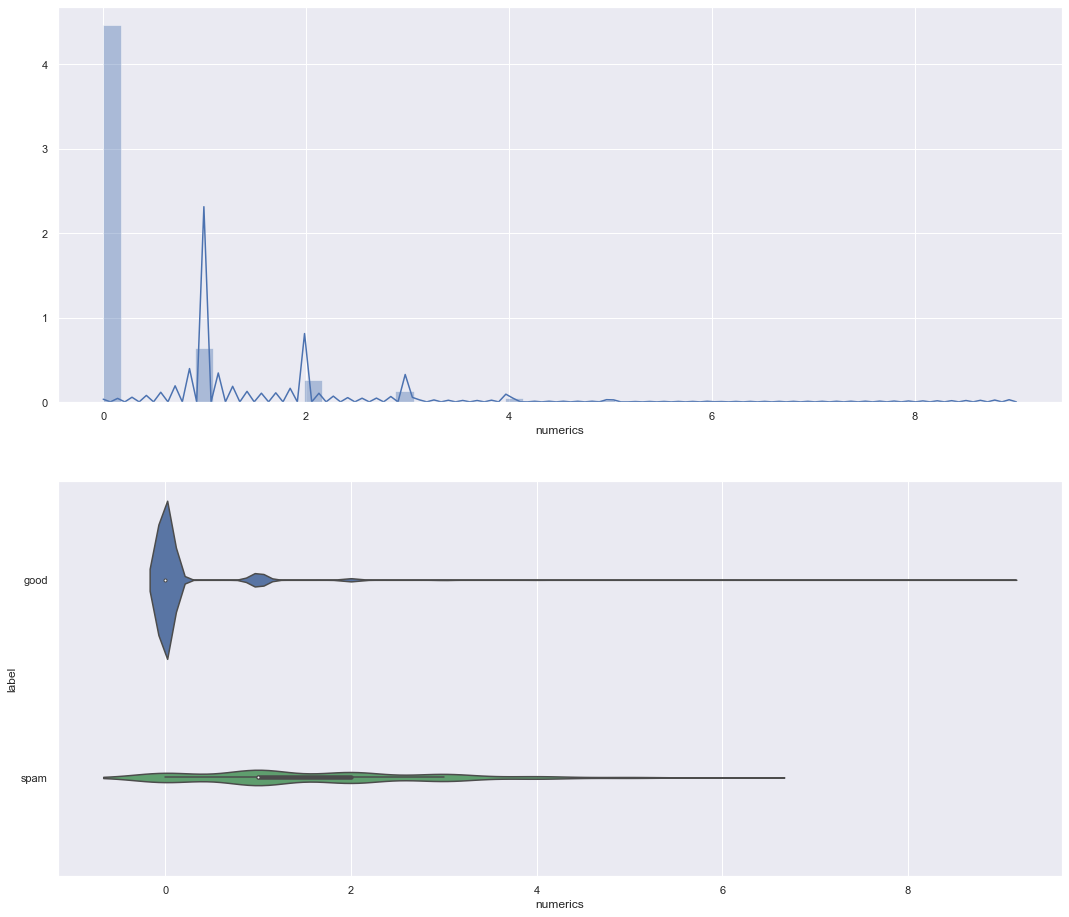

In [23]:
f, axes = plt.subplots(2, 1, figsize=(18,16))

sb.distplot(smsData['numerics'], ax = axes[0])
sb.violinplot(x=smsData['numerics'], y=smsData['label'], ax = axes[1])

#### Feature #6: Number of Upper Words

In [24]:
# number of uppercase words

smsData['upper'] = smsData['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
smsData.head()

,label,text,spam,char count,word count,avg word len,stopwords,special char,numerics,upper
0,good,"Go until jurong point, crazy.. Available only ...",0,111,20,4.600000,4,9,0,0
1,good,Ok lar... Joking wif u oni...,0,29,6,4.000000,0,6,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,28,4.571429,5,6,2,2
3,good,U dun say so early hor... U c already then say...,0,49,11,3.545455,2,6,0,2
4,good,"Nah I don't think he goes to usf, he lives aro...",0,61,13,3.769231,5,2,0,1


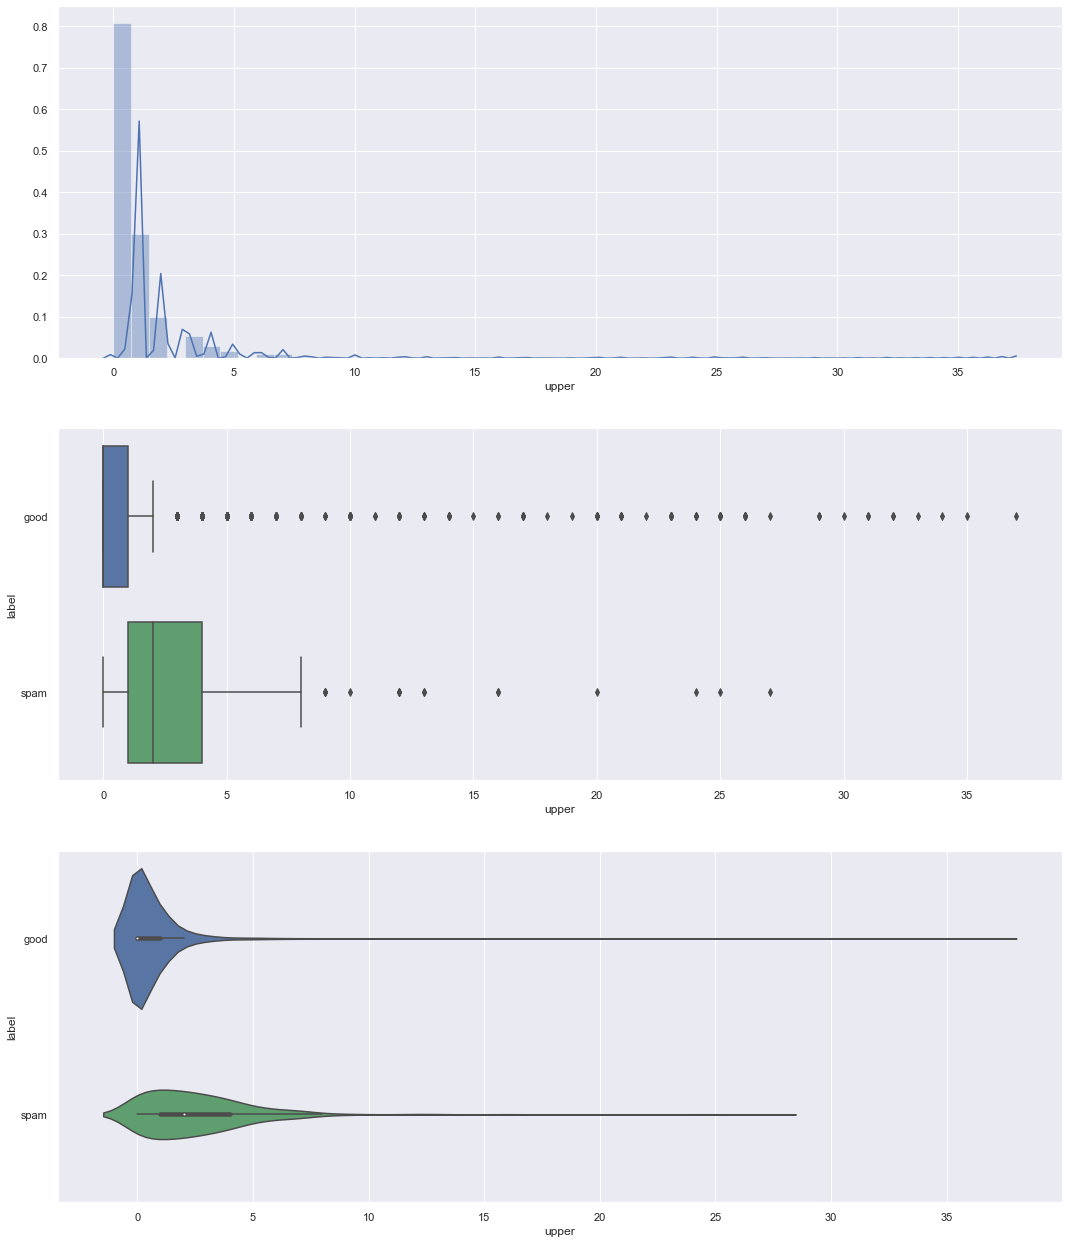

In [25]:
f, axes = plt.subplots(3, 1, figsize=(18,22))

sb.distplot(smsData['upper'], ax = axes[0])
sb.boxplot(x=smsData['upper'], y=smsData['label'], orient = "h", ax = axes[1])
sb.violinplot(x=smsData['upper'], y=smsData['label'], ax = axes[2])

From the above graphs, it is observed that the 'spam' and 'good' texts generally have differences in certain features such as number of punctuations, numerics, and upper case words. Hence, these features will be used to help us predict whether the text is a 'spam' or a 'good' message. 

### Cleaning the data

1. Change all Letters to Lowercase
2. Remove the punctuations
3. Remove stopwords
4. Remove Rare Words
5. Correct Spellings
6. Lemmatize

In [26]:
# 1. change all letters to lowercase

smsData['text']= smsData['text'].apply(lambda x:" ".join(x.lower() for x in x.split()))
smsData.head()

,label,text,spam,char count,word count,avg word len,stopwords,special char,numerics,upper
0,good,"go until jurong point, crazy.. available only ...",0,111,20,4.600000,4,9,0,0
1,good,ok lar... joking wif u oni...,0,29,6,4.000000,0,6,0,0
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1,155,28,4.571429,5,6,2,2
3,good,u dun say so early hor... u c already then say...,0,49,11,3.545455,2,6,0,2
4,good,"nah i don't think he goes to usf, he lives aro...",0,61,13,3.769231,5,2,0,1


In [27]:
# 2. remove punctuation

smsData['text'] = smsData['text'].str.replace('[^\w\s]', '')
smsData.head()

,label,text,spam,char count,word count,avg word len,stopwords,special char,numerics,upper
0,good,go until jurong point crazy available only in ...,0,111,20,4.600000,4,9,0,0
1,good,ok lar joking wif u oni,0,29,6,4.000000,0,6,0,0
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1,155,28,4.571429,5,6,2,2
3,good,u dun say so early hor u c already then say,0,49,11,3.545455,2,6,0,2
4,good,nah i dont think he goes to usf he lives aroun...,0,61,13,3.769231,5,2,0,1


In [28]:
# 3. remove stop words

stop = stopwords.words('english')
smsData['text'] = smsData['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
smsData.head()

,label,text,spam,char count,word count,avg word len,stopwords,special char,numerics,upper
0,good,go jurong point crazy available bugis n great ...,0,111,20,4.600000,4,9,0,0
1,good,ok lar joking wif u oni,0,29,6,4.000000,0,6,0,0
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,1,155,28,4.571429,5,6,2,2
3,good,u dun say early hor u c already say,0,49,11,3.545455,2,6,0,2
4,good,nah dont think goes usf lives around though,0,61,13,3.769231,5,2,0,1


#### Feature #8 Number of Rare Words

In [29]:
# Create a list with the top 100 Rare Words in the texts
freq_rare = pd.Series(' '.join(smsData['text']).split()).value_counts()[-100:]
freq_rare = list(freq_rare.index)

In [30]:
freq_rare

['nikiyu4net',
 'packalso',
 'vibrant',
 'personmeet',
 '1010',
 'trends',
 'applyed',
 'supreme',
 'jot',
 'crashed',
 'outages',
 'mumhas',
 'jap',
 'mustprovide',
 'becz',
 'zhong',
 'goalsteam',
 '0125698789',
 'loo',
 'ltdhelpdesk',
 '5mls',
 'youuuuu',
 'opponenter',
 'sao',
 'entire',
 'cr',
 'isvimportant',
 'shoul',
 'irritated',
 'resolved',
 'frndz',
 'ham',
 'photoshop',
 'margin',
 'chad',
 'intha',
 'artists',
 'shitstorm',
 'geoenvironmental',
 'kyou',
 'somethings',
 'readyall',
 'sthis',
 'dd',
 'alls',
 'ngage',
 '80160',
 '08719839835',
 'papa',
 'drms',
 'ymca',
 'itxt',
 '40mph',
 'cuddled',
 '150week',
 'restrictions',
 'dang',
 'darkest',
 'hmv1',
 'ericson',
 'haunt',
 'phasing',
 'evo',
 'buyer',
 'bandages',
 'asthere',
 'l8',
 'reslove',
 '2exit',
 'writhing',
 'myparents',
 'worklove',
 'ratio',
 'callingforgot',
 'yagoing',
 'ripped',
 'rodds1',
 'gymnastics',
 'forwarding',
 'achieve',
 'pressure',
 'imf',
 'predicting',
 'percentages',
 'todo',
 'swayze',

In [31]:
smsData['no of rare words'] = smsData['text'].apply(lambda x:len([x for x in x.split() if x in freq_rare]))
smsData.head()

,label,text,spam,char count,word count,avg word len,stopwords,special char,numerics,upper,no of rare words
0,good,go jurong point crazy available bugis n great ...,0,111,20,4.600000,4,9,0,0,0
1,good,ok lar joking wif u oni,0,29,6,4.000000,0,6,0,0,0
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,1,155,28,4.571429,5,6,2,2,0
3,good,u dun say early hor u c already say,0,49,11,3.545455,2,6,0,2,0
4,good,nah dont think goes usf lives around though,0,61,13,3.769231,5,2,0,1,0


In [32]:
# 4. Remove the Top 100 Rare Words
smsData['text'] = smsData['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_rare))
smsData.head()

,label,text,spam,char count,word count,avg word len,stopwords,special char,numerics,upper,no of rare words
0,good,go jurong point crazy available bugis n great ...,0,111,20,4.600000,4,9,0,0,0
1,good,ok lar joking wif u oni,0,29,6,4.000000,0,6,0,0,0
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,1,155,28,4.571429,5,6,2,2,0
3,good,u dun say early hor u c already say,0,49,11,3.545455,2,6,0,2,0
4,good,nah dont think goes usf lives around though,0,61,13,3.769231,5,2,0,1,0


In [33]:
# 5. Spelling Correction

from textblob import TextBlob 

smsData['text'].apply(lambda x: str(TextBlob(x).correct()))

0       go during point crazy available boris n great ...
1                                   ok war joking if u on
2       free entry 2 wily come win a cup final this mu...
3                     u dun say early for u c already say
4               ah dont think goes us lives around though
                              ...                        
5567    and time tried 2 contact u u 750 pound prize 2...
5568                          ü b going esplanade fr home
5569                            pity mood any suggestions
5570    guy itching acted like id interested buying so...
5571                                       roll true name
Name: text, Length: 5572, dtype: object

In [34]:
# 6. Lemmatize

from textblob import Word

smsData['text'] = smsData['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
smsData.head()

,label,text,spam,char count,word count,avg word len,stopwords,special char,numerics,upper,no of rare words
0,good,go jurong point crazy available bugis n great ...,0,111,20,4.600000,4,9,0,0,0
1,good,ok lar joking wif u oni,0,29,6,4.000000,0,6,0,0,0
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,1,155,28,4.571429,5,6,2,2,0
3,good,u dun say early hor u c already say,0,49,11,3.545455,2,6,0,2,0
4,good,nah dont think go usf life around though,0,61,13,3.769231,5,2,0,1,0


#### Features: Top 100 Words in #8 : Spam Texts and #9  : Good Texts

In [36]:
# Create a list containing the texts in 'good' texts and 'spam' texts

data_good = smsData[smsData['spam']==0].copy()
data_spam = smsData[smsData['spam']==1].copy()

In [37]:
# Create a function to generate a wordcloud

def show_wordcloud(data_spam_or_good, title):
    msg = ' '.join(data_spam_or_good['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, background_color='lightgrey',
                                       colormap='viridis', width=800, height=600).generate(msg)
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

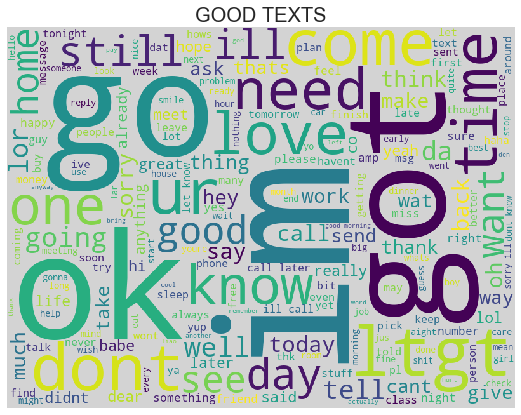

In [38]:
show_wordcloud(data_good, "GOOD TEXTS")

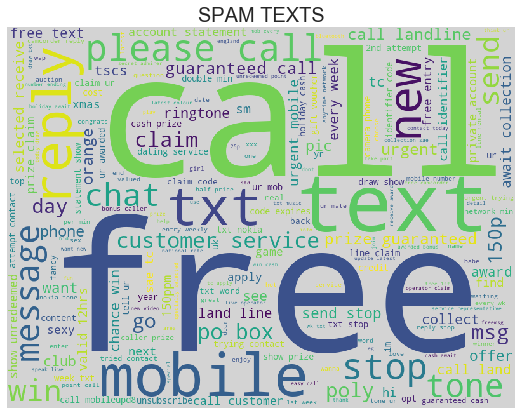

In [39]:
show_wordcloud(data_spam, "SPAM TEXTS")

In [40]:
from collections import Counter

In [41]:
stop_words = set(stopwords.words('english'))

# create a function to tokenize the texts 
def tokenize(text):
    exclude = set(string.punctuation)
    #remove punctuation
    regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]') 
    text = regex.sub(' ', text)
    # tokenize the text
    tokens = nltk.word_tokenize(text)
    # remove stop words
    tokens = list(filter(lambda x: x.lower() not in stop_words, tokens))
    # remove words with length less than 3
    tokens = [w.lower() for w in tokens if len(w) >=3] 
    tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
    return tokens

In [42]:
# create sub-dataframe of spam text
spam_data = smsData[smsData['label'] == 'spam']

# sub-dataframe of good text
good_data = smsData[smsData['label'] == 'good']

spam_data['tokens'] = spam_data['text'].map(tokenize)
good_data['tokens'] = good_data['text'].map(tokenize)

# combine text in different columns in one list:

spam_words = []
for token in spam_data['tokens']:
    spam_words = spam_words + token 
    
good_words = []
for token in good_data['tokens']:
    good_words += token

# convert the list into a string for the subsequent functions 
spam_words_str = ' '.join(spam_words)
good_words_str = ' '.join(good_words)


/Users/pooja/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/pooja/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
freq_good = pd.Series(good_words_str.split()).value_counts()
freq_good

get         320
dont        277
ltgt        276
come        246
got         245
           ... 
among         1
yday          1
xin           1
arrived       1
internal      1
Length: 6534, dtype: int64

In [44]:
freq_spam = pd.Series(spam_words_str.split()).value_counts()[:100]
freq_spam

call           374
free           221
txt            152
text           138
mobile         137
              ... 
name            19
unsubscribe     18
land            18
price           18
mths            18
Length: 100, dtype: int64

In [45]:
smsData['no of spam words'] = smsData['text'].apply(lambda x: len([x for x in x.split() if x in freq_spam]))
smsData['no of good words'] = smsData['text'].apply(lambda x:len([x for x in x.split() if x in freq_good]))

smsData.head()

,label,text,spam,char count,word count,avg word len,stopwords,special char,numerics,upper,no of rare words,no of spam words,no of good words
0,good,go jurong point crazy available bugis n great ...,0,111,20,4.600000,4,9,0,0,0,0,12
1,good,ok lar joking wif u oni,0,29,6,4.000000,0,6,0,0,0,0,4
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,1,155,28,4.571429,5,6,2,2,0,8,10
3,good,u dun say early hor u c already say,0,49,11,3.545455,2,6,0,2,0,0,6
4,good,nah dont think go usf life around though,0,61,13,3.769231,5,2,0,1,0,1,7


In [46]:
# description of the different features after sorting into spam and good messages:
smsData.groupby("label").describe()

spam                                    char count              ...  \
        count mean  std  min  25%  50%  75%  max      count        mean  ...   
label                                                                    ...   
good   4825.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     4825.0   71.450984  ...   
spam    747.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0      747.0  138.629183  ...   

      no of spam words       no of good words                                \
                   75%   max            count      mean       std  min  25%   
label                                                                         
good               1.0  12.0           4825.0  7.085389  5.653717  0.0  3.0   
spam               8.0  14.0            747.0  8.461847  3.097102  0.0  6.0   

                        
       50%   75%   max  
label                   
good   5.0   9.0  80.0  
spam   8.0  10.0  17.0  

[2 rows x 88 columns]

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(smsData['text'])
train_bow

<5572x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 32718 stored elements in Compressed Sparse Row format>

---

## Solution : Classification

Use the labeled (`good`/`spam`) text messages in `smsData` to build a tree-based binary classifier that is capable of distinguishing `spam` text messages from the `good` ones. You may build a single decision tree or an ensemble (forest), whichever is better in this case. Try both, and find out which one is better.        

Response: label (spam/good)

Predictors:
1. Character Count
2. Word Count
3. Average Word Length
4. Number of Stopwords
5. Number of Special Character
6. Number of Numerics
7. Number of Upper Case Words
8. Number of Rare Words
9. Number of Words in the Top 100 Spam Words
10. Number of Words in the Top 100 Good Words



Classification:
1. Multivariate Random Decision Tree
2. Random Forest Classifier 

In [48]:
smsData.head(4)

,label,text,spam,char count,word count,avg word len,stopwords,special char,numerics,upper,no of rare words,no of spam words,no of good words
0,good,go jurong point crazy available bugis n great ...,0,111,20,4.600000,4,9,0,0,0,0,12
1,good,ok lar joking wif u oni,0,29,6,4.000000,0,6,0,0,0,0,4
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,1,155,28,4.571429,5,6,2,2,0,8,10
3,good,u dun say early hor u c already say,0,49,11,3.545455,2,6,0,2,0,0,6


In [49]:
y = pd.DataFrame(smsData['spam'])
x = pd.DataFrame(smsData[['char count', 'word count', 'avg word len', 'stopwords', 'special char', 'numerics', 'upper', 'no of rare words', 'no of spam words', 'no of good words']])

In [50]:
# import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# split the dataset into train and test 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.25)

#check the sample sizes:
print("train set: ", y_train.shape, x_train.shape)
print("test set: ", y_test.shape, x_test.shape)

train set:  (4179, 1) (4179, 10)
test set:  (1393, 1) (1393, 10)


In [53]:
# BASIC EXPLORATION

y_train['spam'].value_counts()

0    3635
1     544
Name: spam, dtype: int64

0 : 'good' texts
1 : 'spam' texts


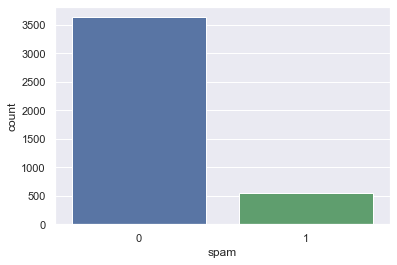

In [54]:
# distribution of response 
print("0 : 'good' texts\n1 : 'spam' texts")
sb.countplot(y_train['spam'])

In [55]:
# summary statistics for predictors
x_train.describe()

,char count,word count,avg word len,stopwords,special char,numerics,upper,no of rare words,no of spam words,no of good words
count,4179.000000,4179.00000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000,4179.000000
mean,79.679588,15.54726,4.272151,4.557550,4.160086,0.321608,1.051926,0.017708,1.383106,7.221584
std,58.889260,11.29240,1.203826,4.417233,4.745861,0.784263,2.838215,0.137238,2.197068,5.334139
min,2.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,7.00000,3.666667,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,61.000000,12.00000,4.100000,3.000000,3.000000,0.000000,0.000000,0.000000,1.000000,6.000000
75%,120.500000,23.00000,4.666667,6.000000,6.000000,0.000000,1.000000,0.000000,2.000000,10.000000
max,790.000000,162.00000,49.000000,77.000000,133.000000,9.000000,37.000000,2.000000,13.000000,69.000000


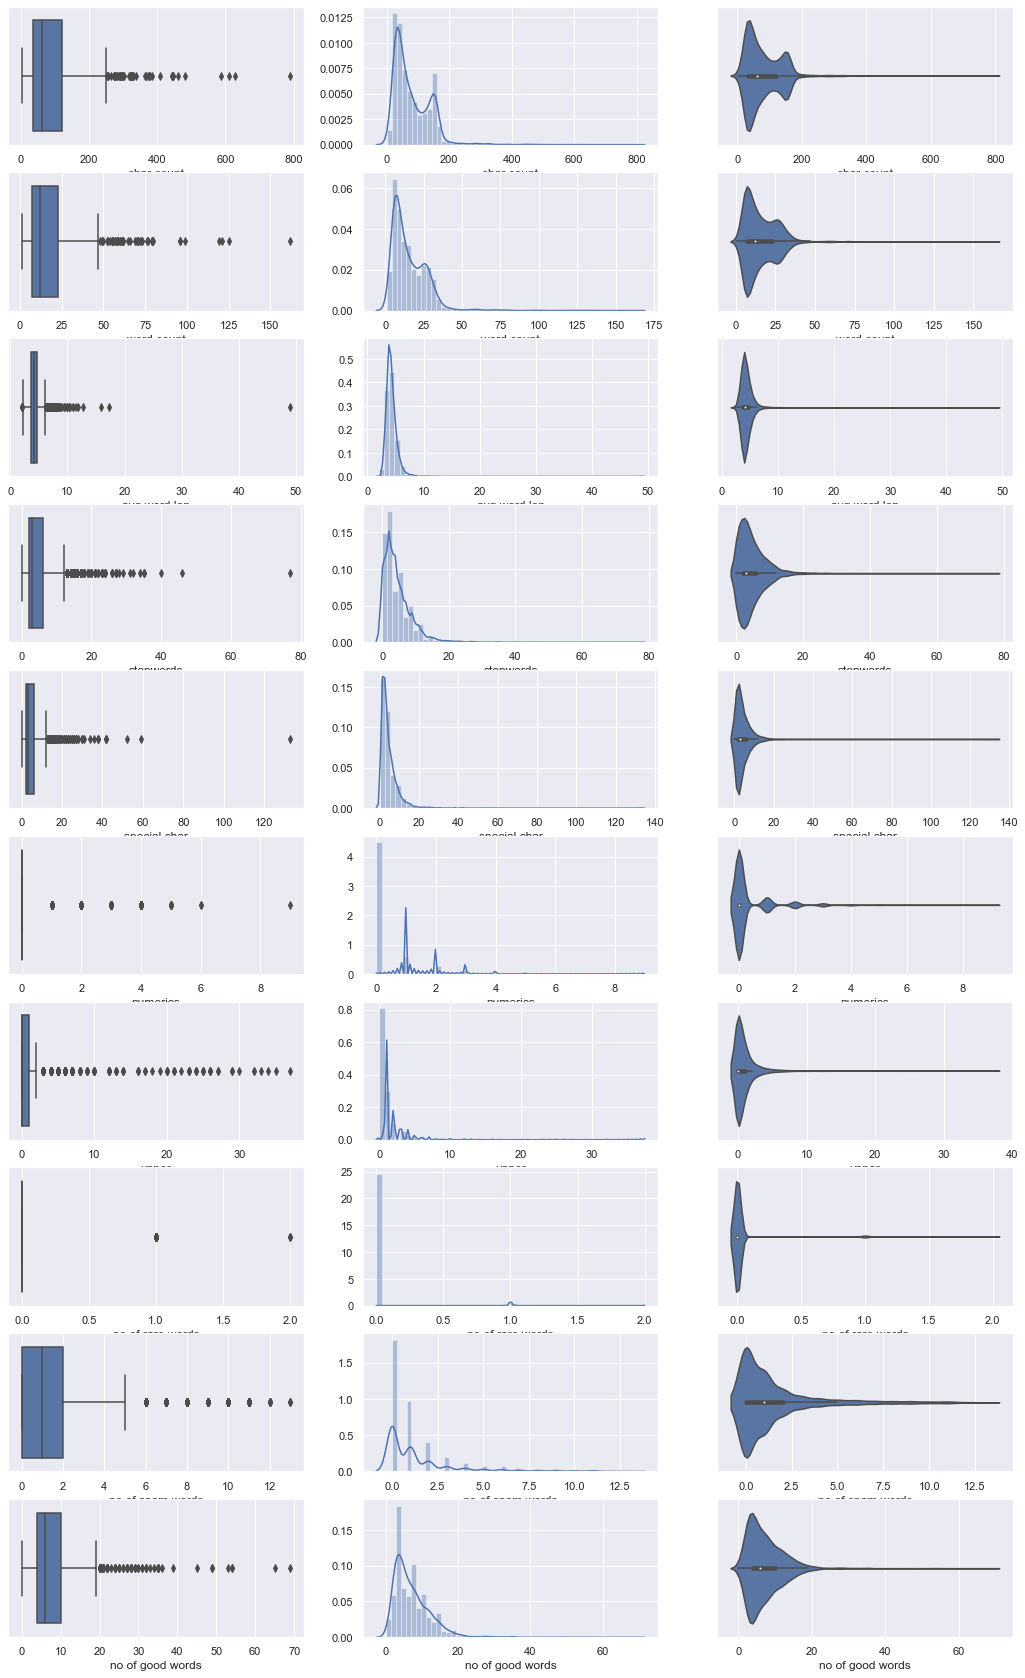

In [64]:
#distribution of all the predictors
f, axes = plt.subplots(10,3, figsize = (18,30))

count = 0
for var in x_train:
    sb.boxplot(x_train[var], orient='h', ax = axes[count,0])
    sb.distplot(x_train[var], ax = axes[count,1])
    sb.violinplot(x_train[var], ax = axes[count, 2])
    count+=1

Order of variables described in the graphs above:
1. Character Count
2. Word Count 
3. Average Word Length
4. Number of Stopwords
5. Number of Special Character
6. Number of Numerics
7. Number of Upper Case Words
8. Number of Rare Words
9. Number of Words in the Top 100 Spam Words
10. Number of Words in the Top 100 Good Words

KeyboardInterrupt: 

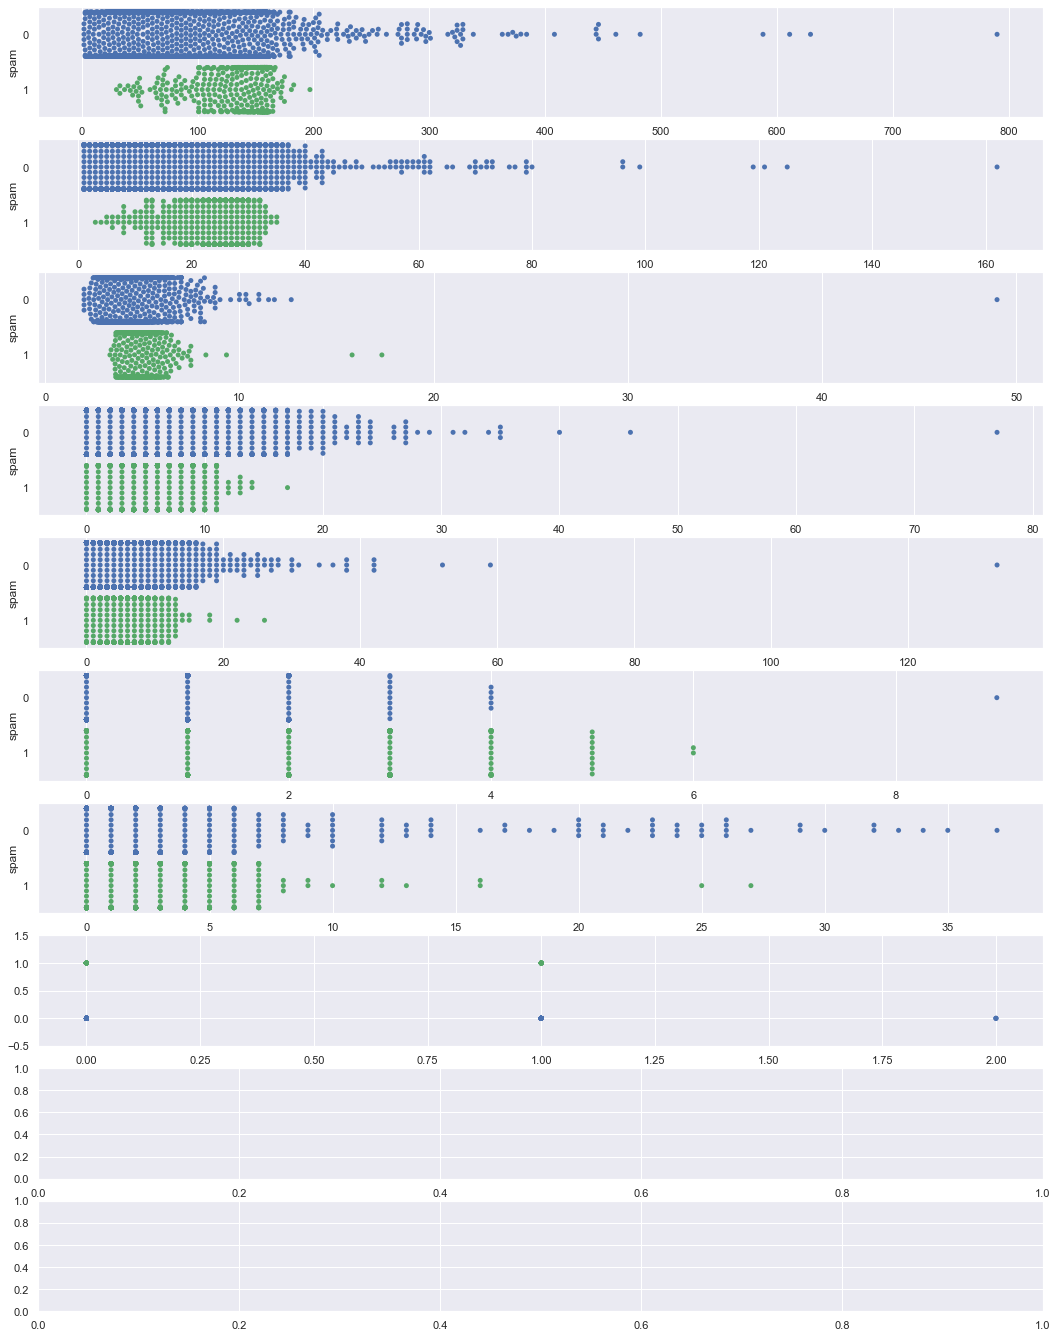

In [90]:
# relationship between response and predictors
trainDF = pd.concat([y_train, x_train.reindex(index=y_train.index)], sort = False, axis = 1)

f, axes = plt.subplots(10, 1, figsize=(18, 24))

count = 0
for var in x_train:
    sb.swarmplot(x = var, y = "spam", data = trainDF, orient = "h", ax = axes[count])
    count += 1

### Model 1 : Multivariate Decision Tree

Goodness of Fit 		Train Dataset
Classification Accuracy 	: 0.973917205072984

Goodness of Fit 		Test Dataset
Classification Accuracy 	: 0.968413496051687


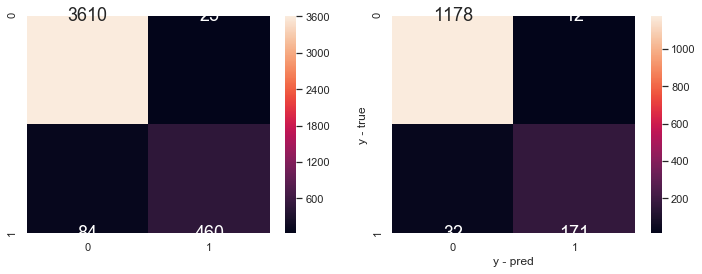

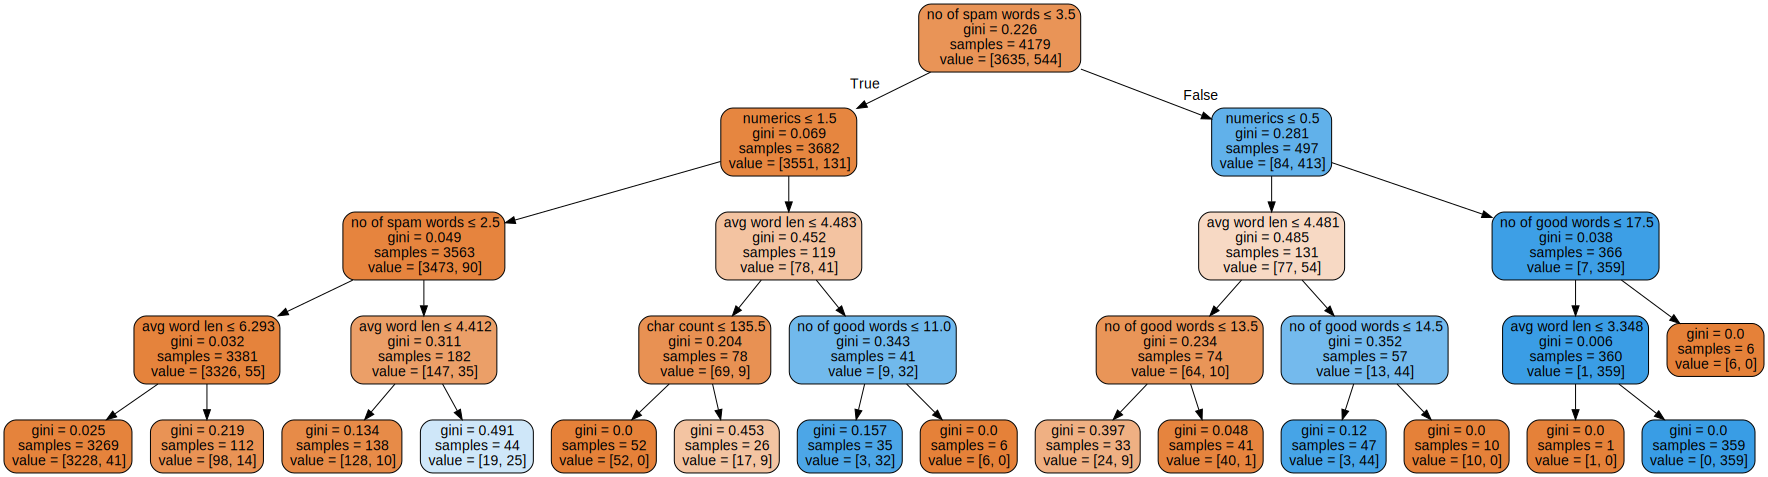

In [69]:
# DECISION TREE

from sklearn.tree import DecisionTreeClassifier

# create a Decision Tree Classifier object 
dectree = DecisionTreeClassifier(max_depth = 4)
dectree.fit(x_train, y_train)

# predict spam messages corresponding to predictors

y_train_pred = dectree.predict(x_train)
y_test_pred = dectree.predict(x_test)

# check goodness of fit (on train data)
print("Goodness of Fit \t\tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(x_train, y_train))
print()

# check goodness of fit (on test data)
print("Goodness of Fit \t\tTest Dataset")
print("Classification Accuracy \t:", dectree.score(x_test, y_test))

# plot the confusion matrix 
f, axes = plt.subplots(1,2,figsize=(12,4))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt = ".0f", annot_kws={"size":18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred),
           annot = True, fmt = ".0f", annot_kws={"size":18}, ax = axes[1])
plt.xlabel("y - pred")
plt.ylabel("y - true")
plt.show()


#plot decision tree
from sklearn.tree import export_graphviz
treedot = export_graphviz(dectree, feature_names = x_train.columns,
                          out_file=None, filled=True, rounded=True, special_characters=True)
import graphviz
graphviz.Source(treedot)

The gini values at the highest level for certain combination of predictors such as [number of spam words -> numerics -> average word lengh -> number of good words] = 0 , which means that there is no possibility of misclassification of 'spam' texts. On the other hand, some branches of the decision tree have a high gini index. Thus, while some predictors are good, others need further refinement or need to be replaced. 

### Model 2 : Random Forest Classifier

In [87]:
from sklearn.ensemble import RandomForestClassifier
# Training the random forest 

# create the random forest object
rforest = RandomForestClassifier(n_estimators=100, max_depth=4)

# fit random forest on train data
rforest.fit(x_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [89]:
# goodness of fit of the model

from sklearn.metrics import confusion_matrix

# detect spam messages corresponding to predictors
y_train_pred = rforest.predict(x_train)
y_test_pred = rforest.predict(x_test)

# check the goodness of fit (on train data)
print("Goodness of Fit \t\tTrain Dataset")
print("Classification Accuracy \t:", rforest.score(x_train, y_train))
print()

# check the goodness of fit (on test data)
print("Goodness of Fit \t\tTest Dataset")
print("Classification Accuracy \t:", rforest.score(x_test, y_test))
print()

Goodness of Fit 		Train Dataset
Classification Accuracy 	: 0.9755922469490309

Goodness of Fit 		Test Dataset
Classification Accuracy 	: 0.9784637473079684



The classification accuracy may be further improved through increasing the depth of the tree. However, this will not be done in this assignment as I wish to keep the depth of the two models same so that they can be more fairly compared. 

In [ ]:
# plot confusion matrix for train and test

f, axes = plt.subplots(1,2,figsize=(12,4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt = ".0f", annot_kws={"size":18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred),
           annot = True, fmt = ".0f", annot_kws={"size":18}, ax = axes[1])
plt.xlabel("y - pred")
plt.ylabel("y - true")
plt.show()

In [80]:
# Prediction of 'spam' messages

smsData_pred = smsData[3458:3465]

In [81]:
# Extract Predictors for Prediction
predictors = ['char count', 'word count', 'avg word len', 'stopwords', 'special char', 'numerics', 'upper', 'no of rare words', 'no of spam words', 'no of good words']
x_pred = pd.DataFrame(smsData_pred[predictors])

# Predict Response corresponding to Predictors
y_pred = rforest.predict(x_pred)
y_pred

array([0, 0, 1, 0, 0, 1, 0])

In [84]:
y_pred = pd.DataFrame(y_pred, columns = ['pred type'], index = smsData_pred.index)
smsData_acc = pd.concat([smsData_pred[['text','label']], y_pred], axis = 1)
smsData_acc

,text,label,pred type
3458,friendship poem dear dear u r near hear dont g...,good,0
3459,lunch come quickly open door,good,0
3460,heard u4 call night knickers make beg like u l...,spam,1
3461,back bit long co accident a30 divert via wadeb...,good,0
3462,k yan jiu liao sat go 4 bugis vill one frm 10 ...,good,0
3463,bloomberg message center 447797706009 wait app...,spam,1
3464,seeking lady street freak sheet,good,0


In [85]:
y_prob = rforest.predict_proba(x_pred)
np.set_printoptions(precision = 3)
print(y_prob)

[[0.98  0.02 ]
 [0.997 0.003]
 [0.298 0.702]
 [0.983 0.017]
 [0.931 0.069]
 [0.283 0.717]
 [0.99  0.01 ]]


### CONCLUSION

##### Model 1: Multivariate Decision Tree

Classification Accuracy : 0.97392 (Train); 0.96841 (Test)
 
##### Model 2: Random Forest Classification

Classification Accuracy : 0.97559 (Train); 0.97846 (Test)


The Multivariate Decision Tree is a useful model as it uses all the predictors and has a high accuracy. In fact, in this data, the Classification Accuracy of the both the train and test data from model 1 are only slightly lower than that of model 2. 

The Random Forest is a better model to predict whether a text message is a spam, as it uses randomly chosen predictors to build the model, rather than just a single Classification Tree. Hence, it is hence more diverse and hollistic than a Decision Tree.


Potential Improvements:

1. This model can be improved by creating another tree/forest for prediction based on the occurence of specific words from top 100 'spam' texts and top 100 'good' texts

2. The use of univariate Decision Tree and a Correlation Matrix may be used to determine how useful each of the predicators are. The less accurate predictors may hence be replaced or improved upon. 

3. A TF-IDF model may be considered as it uses Term Frequency and Inverse Document Frequency (informativeness of the term) to determine a Matching Score. This is more useful than the other models used in this assignment as it is more robust in processing textual data. 

### References 

1. https://towardsdatascience.com/understanding-random-forest-58381e0602d2 
2. https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
3. https://www.kaggle.com/dejavu23/sms-spam-or-ham-beginner
4. https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
5. https://towardsdatascience.com/why-random-forests-outperform-decision-trees-1b0f175a0b5
6. Lecture Slides and Example Classes